In [158]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from torch.optim import Adam
import logging
import pickle, os
import matplotlib.pyplot as plt


In [159]:
class SpatioTemporalLSTMCell(nn.Module):
    def __init__(
        self, in_channel, num_hidden, height, width, filter_size, stride, layer_norm
    ):
        super(SpatioTemporalLSTMCell, self).__init__()

        self.num_hidden = num_hidden
        self.padding = "same"
        self._forget_bias = 1.0
        if layer_norm:
            self.conv_x = nn.Sequential(
                nn.Conv2d(
                    in_channel,
                    num_hidden * 7,
                    kernel_size=filter_size,
                    stride=stride,
                    padding=self.padding,
                    bias=False,
                ),
                nn.LayerNorm([num_hidden * 7, height, width]),
            )
            self.conv_h = nn.Sequential(
                nn.Conv2d(
                    num_hidden,
                    num_hidden * 4,
                    kernel_size=filter_size,
                    stride=stride,
                    padding=self.padding,
                    bias=False,
                ),
                nn.LayerNorm([num_hidden * 4, height, width]),
            )
            self.conv_m = nn.Sequential(
                nn.Conv2d(
                    num_hidden,
                    num_hidden * 3,
                    kernel_size=filter_size,
                    stride=stride,
                    padding=self.padding,
                    bias=False,
                ),
                nn.LayerNorm([num_hidden * 3, height, width]),
            )
            self.conv_o = nn.Sequential(
                nn.Conv2d(
                    num_hidden * 2,
                    num_hidden,
                    kernel_size=filter_size,
                    stride=stride,
                    padding=self.padding,
                    bias=False,
                ),
                nn.LayerNorm([num_hidden, height, width]),
            )
        else:
            self.conv_x = nn.Sequential(
                nn.Conv2d(
                    in_channel,
                    num_hidden * 7,
                    kernel_size=filter_size,
                    stride=stride,
                    padding=self.padding,
                    bias=False,
                ),
            )
            self.conv_h = nn.Sequential(
                nn.Conv2d(
                    num_hidden,
                    num_hidden * 4,
                    kernel_size=filter_size,
                    stride=stride,
                    padding=self.padding,
                    bias=False,
                ),
            )
            self.conv_m = nn.Sequential(
                nn.Conv2d(
                    num_hidden,
                    num_hidden * 3,
                    kernel_size=filter_size,
                    stride=stride,
                    padding=self.padding,
                    bias=False,
                ),
            )
            self.conv_o = nn.Sequential(
                nn.Conv2d(
                    num_hidden * 2,
                    num_hidden,
                    kernel_size=filter_size,
                    stride=stride,
                    padding=self.padding,
                    bias=False,
                ),
            )
        self.conv_last = nn.Conv2d(
            num_hidden * 2, num_hidden, kernel_size=1, stride=1, padding=0, bias=False
        )

    def forward(self, x_t, h_t, c_t, m_t):
        x_concat = self.conv_x(x_t)
        h_concat = self.conv_h(h_t)
        m_concat = self.conv_m(m_t)
        i_x, f_x, g_x, i_x_prime, f_x_prime, g_x_prime, o_x = torch.split(
            x_concat, self.num_hidden, dim=1
        )
        i_h, f_h, g_h, o_h = torch.split(h_concat, self.num_hidden, dim=1)
        i_m, f_m, g_m = torch.split(m_concat, self.num_hidden, dim=1)

        i_t = torch.sigmoid(i_x + i_h)
        f_t = torch.sigmoid(f_x + f_h + self._forget_bias)
        g_t = torch.tanh(g_x + g_h)

        c_new = f_t * c_t + i_t * g_t

        i_t_prime = torch.sigmoid(i_x_prime + i_m)
        f_t_prime = torch.sigmoid(f_x_prime + f_m + self._forget_bias)
        g_t_prime = torch.tanh(g_x_prime + g_m)

        m_new = f_t_prime * m_t + i_t_prime * g_t_prime

        mem = torch.cat((c_new, m_new), 1)
        o_t = torch.sigmoid(o_x + o_h + self.conv_o(mem))
        h_new = o_t * torch.tanh(self.conv_last(mem))

        return h_new, c_new, m_new



In [160]:
class RNN(nn.Module):
    def __init__(self, num_layers, num_hidden, configs):
        super(RNN, self).__init__()

        # Nirand: here I will assume that total_length and input_length is the same, which is equal to seq_length
        assert configs.total_length == configs.input_length

        # Nirand: I don't think that this code support different num_hidden values in each layer.
        assert np.unique(num_hidden).shape[0] == 1

        # Nirand: require the type of filter to be tuple
        assert type(configs.filter_size) == tuple

        # Nirand: I do not think this code can use any other stride values apart from 1
        assert configs.stride == 1

        # Nirand: not sure what patch_size is. Make sure it is 1.
        assert configs.patch_size == 1

        self.configs = configs
        self.frame_channel = (
            configs.patch_size * configs.patch_size * configs.img_channel
        )
        self.num_layers = num_layers
        self.num_hidden = num_hidden
        cell_list = []

        width = configs.img_width // configs.patch_size
        height = configs.img_height // configs.patch_size

        self.MSE_criterion = nn.MSELoss()

        for i in range(num_layers):
            in_channel = self.frame_channel if i == 0 else num_hidden[i - 1]
            cell_list.append(
                SpatioTemporalLSTMCell(
                    in_channel,
                    num_hidden[i],
                    height,
                    width,
                    configs.filter_size,
                    configs.stride,
                    configs.layer_norm,
                )
            )
        self.cell_list = nn.ModuleList(cell_list)
        self.conv_last = nn.Conv2d(
            num_hidden[num_layers - 1],
            self.frame_channel,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )

    def forward(self, frames):
        # assume [batch, seq_length, channel, height, width]
        batch = frames.shape[0]
        height = frames.shape[3]
        width = frames.shape[4]

        next_frames = []
        h_t = []
        c_t = []

        for i in range(self.num_layers):
            zeros = torch.zeros([batch, self.num_hidden[i], height, width])
            h_t.append(zeros)
            c_t.append(zeros)

        memory = torch.zeros([batch, self.num_hidden[0], height, width])

        for t in range(self.configs.total_length):

            net = frames[:, t]

            h_t[0], c_t[0], memory = self.cell_list[0](net, h_t[0], c_t[0], memory)

            for i in range(1, self.num_layers):
                h_t[i], c_t[i], memory = self.cell_list[i](
                    h_t[i - 1], h_t[i], c_t[i], memory
                )

            x_gen = self.conv_last(h_t[self.num_layers - 1])
            next_frames.append(x_gen)

        # [batch, seq_length, channel, height, width]
        next_frames = torch.stack(next_frames, dim=1).contiguous()
        return next_frames


In [161]:
class Configs:
    def __init__(
        self,
        patch_size,
        stride,
        img_height,
        img_width,
        img_channel,
        layer_norm,
        filter_size,
        input_length,
        total_length,
    ):
        self.patch_size = patch_size
        self.stride = stride
        self.img_height = img_height
        self.img_width = img_width
        self.img_channel = img_channel
        self.layer_norm = layer_norm
        self.filter_size = filter_size
        self.input_length = input_length
        self.total_length = total_length


### Experimenting


In [162]:
# num_layers = 3
# num_hidden = [
#     30,
#     30,
#     30,
# ]  # Hidden layer channel. Note that this code does not support different number of hidden filters for each layer
# patch_size = 1
# stride = 1
# img_width = 32
# img_height = 32
# layer_norm = True
# filter_size = (5, 5)
# img_channel = 3
# # Not sure what is the different between input_length and sequence_length. But I will set it equal for now.
# input_length = 10  # Sequence length
# total_length = input_length

# configs = Configs(
#     patch_size=patch_size,
#     stride=stride,
#     img_height=img_height,
#     img_width=img_width,
#     img_channel=img_channel,
#     layer_norm=layer_norm,
#     filter_size=filter_size,
#     input_length=input_length,
#     total_length=total_length,
# )



In [163]:
# batch_size = 11
# seq_length = 10
# in_channel = 3
# model = RNN(num_layers=num_layers, num_hidden=num_hidden, configs=configs)
# X = torch.rand(batch_size, seq_length, in_channel, img_width, img_width)
# pred = model(X)
# print(pred.size())


### Experimenting with PFC data


In [164]:
num_layers = 3
num_hidden = [
    30,
    30,
    30,
]  # Hidden layer channel. Note that this code does not support different number of hidden filters for each layer
patch_size = 1
stride = 1
img_height = 1
img_width = 32
layer_norm = True
filter_size = (5, 5)
img_channel = 1
# Not sure what is the different between input_length and sequence_length. But I will set it equal for now.
input_length = 10  # Sequence length
total_length = input_length

configs = Configs(
    patch_size=patch_size,
    stride=stride,
    img_height=img_height,
    img_width=img_width,
    img_channel=img_channel,
    layer_norm=layer_norm,
    filter_size=filter_size,
    input_length=input_length,
    total_length=total_length,
)

model = RNN(num_layers=num_layers, num_hidden=num_hidden, configs=configs)



d:\Work\Coding\research\pfc-ml\T02 - PFC - ConvLSTM\output\2022-05-08-07-21-22\data_store.pickle


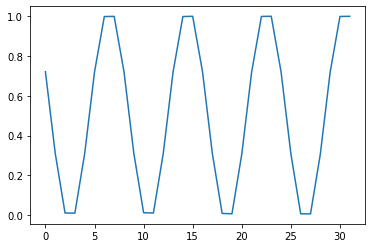

In [165]:
# Data folder
cwd = os.getcwd()
folderPFC = "T02 - PFC - ConvLSTM"
folderOutput = "2022-05-08-07-21-22"
rootFolder = os.path.dirname(cwd)  # Up one level
filePath = os.path.join(
    rootFolder, folderPFC, "output", folderOutput, "data_store.pickle"
)
print(filePath)

# Load data (deserialize)
with open(filePath, "rb") as handle:
    data_dict = pickle.load(handle)

data = data_dict["data"]
# nCol = data_dict["n"]
# nRow = 1
# nChannel = 1
# tFinal = data_dict["tf"]
# dx = data_dict["dx"]
# L = data_dict["L"]

# Due to sigmoid function, the output cannot be negative.  I could however, use linear layer to fix this?
maxVal = data.max()
minVal = data.min()
dataScaled = (data - minVal) / (maxVal - minVal)
plt.plot(dataScaled[-1, :])


In [166]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, seq_length, num_channels, frame_size):
        X_, y_ = self.split_sequence(data, seq_length)
        X_ = X_.reshape(X_.shape[0], num_channels, seq_length, *frame_size)
        self.X = torch.from_numpy(
            X_
        ).float()  # numpy array data is double but the parameters in the nn layers are float.
        self.y = torch.from_numpy(y_).float()

    def __len__(self):
        "Denotes the total number of samples"
        return self.X.shape[0]

    # Probabably a better way here: https://diegslva.github.io/2017-05-02-first-post/
    def split_sequence(self, data, nSeq):
        X, y = list(), list()
        nRow = data.shape[0]
        for i in range(nRow):
            # find the end of this pattern
            end_ix = i + nSeq
            # check if we are beyond the sequence
            if end_ix > nRow - 1:
                break
                # gather input and output parts of the pattern
            seq_x, seq_y = data[i:end_ix, :], data[end_ix, :]
            X.append(seq_x)
            y.append(seq_y)
        return np.array(X), np.array(y)

    def __getitem__(self, index):
        "Generates one sample of data"
        # Select sample
        X = self.X[index]
        y = self.y[index]
        X = X.transpose(0, 1)  # Change to seq_len, channel, H, W)
        return X, y



In [167]:
frame_size = (img_height, img_width)
batch_size = 12
seq_length = input_length
num_channels = img_channel

ds = MyDataset(dataScaled, seq_length, num_channels, frame_size)
train_loader = DataLoader(ds, shuffle=True, batch_size=batch_size)


torch.Size([12, 10, 1, 1, 32])
torch.Size([12, 32])


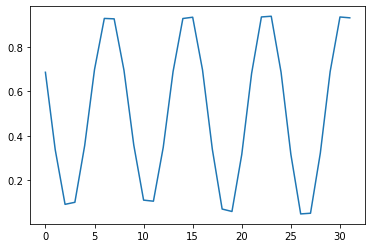

In [168]:
train_, phi_ = next(iter(train_loader))
print(train_.shape)
print(phi_.shape)
train = train_[0, 0, -1, 0, :].cpu().detach().numpy()
plt.plot(train)
plt.show()


In [169]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(
        self, patience=7, verbose=False, delta=0, path="checkpoint.pt", trace_func=print
    ):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(
                f"EarlyStopping counter: {self.counter} out of {self.patience}"
            )
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decrease."""
        if self.verbose:
            self.trace_func(
                f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ..."
            )
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


In [170]:
class History:
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.epoch = []
        self.counter = 1

    def __call__(self, train_loss, val_loss):
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)
        self.epoch.append(self.counter)
        self.counter += 1


In [171]:
num_epochs = 1000
patience = 20
history = History()
optim = Adam(model.parameters(), lr=1e-2)
criterion = nn.MSELoss(reduction="sum")

In [172]:
# num_epochs = 100
# (input, target) = next(iter(train_loader))

# for epoch in range(1, num_epochs + 1):

#     train_loss = 0
#     model.train()  # https://stackoverflow.com/a/51433411
#     outputs = model(input)
#     output = outputs[:, -1, ...]
#     loss = criterion(output.flatten(), target.flatten())
#     loss.backward()
#     optim.step()
#     optim.zero_grad()
#     train_loss += loss.item()
#     train_loss /= batch_size

#     val_loss = 0
#     model.eval()
#     with torch.no_grad():
#         outputs = model(input)
#         output = outputs[:, -1, ...]
#         loss = criterion(output.flatten(), target.flatten())
#         val_loss += loss.item()
#     val_loss /= batch_size

#     print(
#         "Epoch:{} Training Loss:{:.8f} Validation Loss:{:.8f}\n".format(
#             epoch, train_loss, val_loss
#         )
#     )

# phiPred = output[-1, 0, 0, :].cpu().detach().numpy()
# phi = target[-1, :].cpu().detach().numpy()
# plt.plot(phi, "--*")
# plt.plot(phiPred)


In [173]:
# run_mode = 'train'
run_mode = 'eval'

In [174]:
if run_mode == 'train':
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    for epoch in range(1, num_epochs + 1):

        train_loss = 0
        model.train()  # https://stackoverflow.com/a/51433411
        for batch_num, (input, target) in enumerate(train_loader, 1):
            outputs = model(input)
            output = outputs[:, -1, ...]
            loss = criterion(output.flatten(), target.flatten())
            loss.backward()
            torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=10.0)
            optim.step()
            optim.zero_grad()
            train_loss += loss.item()
        train_loss /= len(train_loader.dataset)

        val_loss = 0
        model.train()
        with torch.no_grad():
            for input, target in train_loader:
                outputs = model(input)
                output = outputs[:, -1, ...]
                loss = criterion(output.flatten(), target.flatten())
                val_loss += loss.item()
        val_loss /= len(train_loader.dataset)

        history(train_loss, val_loss)
        print(
            "Epoch:{} Training Loss:{:.8f} Validation Loss:{:.8f}\n".format(
                epoch, train_loss, val_loss
            )
        )

        early_stopping(val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

In [175]:
if run_mode == 'eval':
    model.load_state_dict(torch.load('checkpoint-predrnn.pt'))

torch.Size([12, 1, 1, 32])
torch.Size([12, 32])


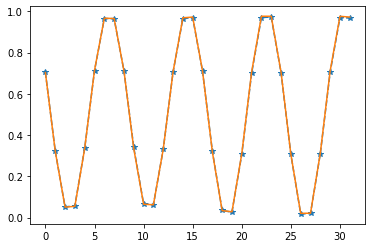

In [179]:
train_, phi_ = next(iter(train_loader))
model.eval()
preds_ = model(train_)
pred_ = preds_[:, -1, ...]
print(pred_.size())
print(phi_.size())

pred = pred_[-1, 0, 0, :].cpu().detach().numpy()
phi = phi_[-1, :].cpu().detach().numpy()
plt.plot(phi, "--*")
plt.plot(pred)